In [3]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

In [93]:
ls "./data/"

 E 드라이브의 볼륨: 로컬 디스크
 볼륨 일련 번호: 5203-F739

 E:\3_2\AIProject\findMyBird\data 디렉터리

2018-12-09  오후 08:37    <DIR>          .
2018-12-09  오후 08:37    <DIR>          ..
2018-12-09  오후 08:35           384,114 Chicken (1).wav
2018-12-09  오후 08:36           384,168 Chicken (2).wav
2018-12-09  오후 08:36           384,114 Chicken (3).wav
2018-12-09  오후 08:37           384,114 Chicken (4).wav
2018-12-09  오후 07:51           384,114 Owl (1).wav
2018-12-09  오후 07:56           384,114 Owl (10).wav
2018-12-09  오후 07:56           384,114 Owl (11).wav
2018-12-09  오후 07:57           384,114 Owl (12).wav
2018-12-09  오후 07:57           384,114 Owl (13).wav
2018-12-09  오후 07:57           384,114 Owl (14).wav
2018-12-09  오후 07:58           384,114 Owl (15).wav
2018-12-09  오후 07:58           384,114 Owl (16).wav
2018-12-09  오후 07:59           384,114 Owl (17).wav
2018-12-09  오후 07:59           384,114 Owl (18).wav
2018-12-09  오후 08:16           384,114 Owl (19).wav
2018-12-09  오후 07:51           384,114 Owl (

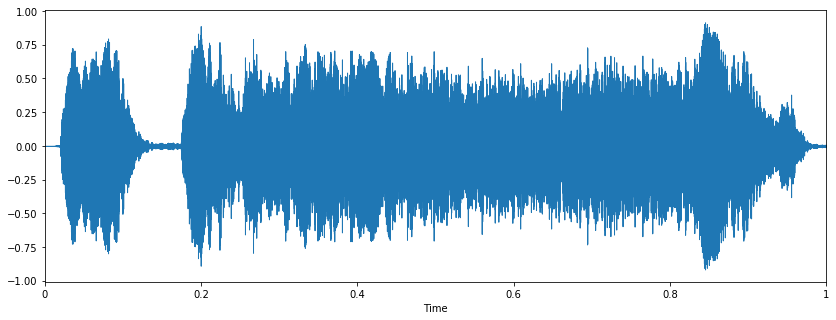

In [94]:
y, sr = librosa.load("./data/Chicken (1).wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

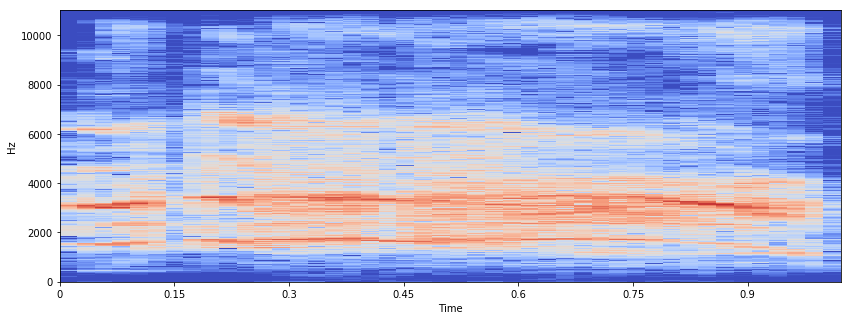

In [95]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [96]:
ipd.Audio('./data/Chicken (2).wav') # load a local WAV file

In [118]:
templist = []
label = [] # 원핫!

for i in range(1, 37):
    y, sr = librosa.load("./data/Owl ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    templist.append(mfcc)
    label.append(np.array([1,0]))
    
for i in range(1, 4):
    y, sr = librosa.load("./data/Chicken ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    templist.append(mfcc)
    label.append(np.array([0,1]))
    
dataset = np.asarray(templist)
label = np.asarray(label)
dataset.shape

(39, 20, 44)

In [119]:
label.shape

(39, 2)

In [120]:
tf.reset_default_graph()
#########
# 옵션 설정
######
learning_rate = 0.001
total_epoch = 30
batch_size = 1

# RNN 은 순서가 있는 자료를 다루므로,
# 한 번에 입력받는 갯수와, 총 몇 단계로 이루어져있는 데이터를 받을지를 설정해야합니다.
# 이를 위해 가로 픽셀수를 n_input 으로, 세로 픽셀수를 입력 단계인 n_step 으로 설정하였습니다.
n_input = mfcc.shape[1]
n_step = mfcc.shape[0]
n_hidden = 128
n_class = 2

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32, [None, n_step, n_input])
Y = tf.placeholder(tf.float32, [None, n_class])

W = tf.Variable(tf.random_normal([n_hidden, n_class]))
b = tf.Variable(tf.random_normal([n_class]))

# RNN 에 학습에 사용할 셀을 생성합니다
# 다음 함수들을 사용하면 다른 구조의 셀로 간단하게 변경할 수 있습니다
# BasicRNNCell,BasicLSTMCell,GRUCell
cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)

# RNN 신경망을 생성합니다
# 원래는 다음과 같은 과정을 거쳐야 하지만
# states = tf.zeros(batch_size)
# for i in range(n_step):
#     outputs, states = cell(X[[:, i]], states)
# ...
# 다음처럼 tf.nn.dynamic_rnn 함수를 사용하면
# CNN 의 tf.nn.conv2d 함수처럼 간단하게 RNN 신경망을 만들어줍니다.
# 겁나 매직!!
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# 결과를 Y의 다음 형식과 바꿔야 하기 때문에
# Y : [batch_size, n_class]
# outputs 의 형태를 이에 맞춰 변경해야합니다.
# outputs : [batch_size, n_step, n_hidden]
#        -> [n_step, batch_size, n_hidden]
#        -> [batch_size, n_hidden]
outputs = tf.transpose(outputs, [1, 0, 2])
outputs = outputs[-1]
model = tf.matmul(outputs, W) + b

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#########
# 신경망 모델 학습
######
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = len(dataset) #int(mnist.train.num_examples/batch_size)

for epoch in range(total_epoch):
    total_cost = 0

    for i in range(total_batch):
        batch_xs, batch_ys = (dataset[i], np.array([label[i]]))
        # X 데이터를 RNN 입력 데이터에 맞게 [batch_size, n_step, n_input] 형태로 변환합니다.
        batch_xs = batch_xs.reshape((batch_size, n_step, n_input))

        _, cost_val = sess.run([optimizer, cost],
                               feed_dict={X: batch_xs, Y: batch_ys})
        total_cost += cost_val

    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost =', '{}'.format(total_cost / total_batch))

print('최적화 완료!')


Epoch: 0001 Avg. cost = 5.185798297523308
Epoch: 0002 Avg. cost = 1.0134954930597913
Epoch: 0003 Avg. cost = 0.24443225793462867
Epoch: 0004 Avg. cost = 0.05315707141561432
Epoch: 0005 Avg. cost = 0.08449405572343074
Epoch: 0006 Avg. cost = 0.1343492654128704
Epoch: 0007 Avg. cost = 0.05363669100353956
Epoch: 0008 Avg. cost = 0.06654859891799046
Epoch: 0009 Avg. cost = 0.030978115398636527
Epoch: 0010 Avg. cost = 0.10083692714882612
Epoch: 0011 Avg. cost = 0.040103828496674106
Epoch: 0012 Avg. cost = 0.02204225071268932
Epoch: 0013 Avg. cost = 0.010034718185779777
Epoch: 0014 Avg. cost = 0.0037556137105800628
Epoch: 0015 Avg. cost = 0.0031058891563355783
Epoch: 0016 Avg. cost = 0.0023840612199487275
Epoch: 0017 Avg. cost = 0.0018608319315449196
Epoch: 0018 Avg. cost = 0.0017274587236871552
Epoch: 0019 Avg. cost = 0.0016045471745874589
Epoch: 0020 Avg. cost = 0.0015038353629101481
Epoch: 0021 Avg. cost = 0.0014279829732423911
Epoch: 0022 Avg. cost = 0.0013661736976211193
Epoch: 0023 Avg

# 모델 테스트

In [121]:
y, sr = librosa.load("./data/Chicken (4).wav")
test_mfcc = librosa.feature.mfcc(y=y, sr=sr)

test_batch_size = 1
test_xs = test_mfcc.reshape(1, n_step, n_input)

sess.run(model, feed_dict={X:np.array([test_mfcc]), Y:np.array([[1, 0]])})

array([[-7.5916586,  7.5134716]], dtype=float32)

In [122]:
y, sr = librosa.load("./data/Owl (37).wav")
test_mfcc = librosa.feature.mfcc(y=y, sr=sr)

test_batch_size = 1
test_xs = test_mfcc.reshape(1, n_step, n_input)

sess.run(model, feed_dict={X:np.array([test_mfcc]), Y:np.array([[0, 1]])})

array([[6.6830263, 3.2661486]], dtype=float32)